In [1]:
import numpy as np
import tensorflow as tf

# amazingly, this fixes plotting on Harish's Mac!
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [15]:
f = np.load('/Users/hbhat/Google Drive File Stream/My Drive/coultrajnew.npz')
qdat = f['qdat']
pdat = f['pdat']

# remember momentum = mass * velocity
# so we msut set mass of second particle
# pdat[:,:,3:] *= 0.5

n_steps, n_instances, d = qdat.shape
dt = f['dt']
print(dt)
print(qdat.shape)
print(pdat.shape)

0.001
(5001, 100, 6)
(5001, 100, 6)


In [3]:
# this function seeks to ensure reproducibility
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [4]:
def tf_diff_axis_0(a):
    return a[1:]-a[:-1]

# set up a neural network model for a potential function V : R^d --> R
reset_graph()

# here we take both q and p to be n_steps x n_instances x d
qts = tf.placeholder(tf.float32, shape=(None, n_instances, d), name="qts")
pts = tf.placeholder(tf.float32, shape=(None, n_instances, d), name="pts")

# flatten in such a way that we get a two-dimensional matrix consisting of blocks
# each block consists of one instance of dimension n_steps x d
# the number of such blocks is n_instances
q = tf.transpose(tf.layers.flatten(tf.transpose(qts, perm=[2, 1, 0])),perm=[1, 0])

# we know a priori that the potential depends on the difference
qdiff = tf.norm(q[:, 3:] - q[:, :3], axis=1, keepdims=True)

# keep track of outputs of each layer
output = []

# put the inputs in output[0]
output.append(qdiff)

# here is a little Python magic that enables us to define a new function
# called "my_dense_layer" which is the same as the TF function tf.layers.dense
# except that we have preset activation=selu
# ...in short, we have partially evaluated tf.layers.dense...
from functools import partial
my_dense_layer = partial(tf.layers.dense) #,activation=tf.nn.tanh)

depth = 8
numneurons = [8, 8, 8, 8, 8, 8, 8, 8]

# here is where we define our deep neural network
with tf.name_scope("dnn"):
    
    # we iteratively create hidden layers
    for j in range(depth):
        thisname = "hidden" + str(j)
        
        # the input to hidden layer j is outputs[j]
        # the output of hidden layer j is stored in outputs[j+1]
        # this function handles the creation of all weight and bias variables,
        # for each hidden layer!
        if j == (depth-1):
            myact = tf.nn.tanh
        else:
            myact = tf.nn.tanh
        output.append(my_dense_layer(output[j], 
                                     units=numneurons[j],
                                     name=thisname,
                                     activation=myact))

    # to get from the high-dimensional output of the final hidden layer
    # to a scalar output, we use this function, which basically uses 
    # a linear transformation of the form "w^T h + b"
    # --> h is the vector of outputs from the last hidden layer
    # --> w is a weight vector of the same dimension as h
    # --> b is a scalar
    Vpredraw = tf.layers.dense(output[depth], units=1, name='output')
    Vpred = tf.reshape(Vpredraw, shape=[n_instances, n_steps])
    
# automatically differentiate potential and generate gradV : R^d --> R^d
from tensorflow.python.ops.parallel_for.gradients import jacobian, batch_jacobian
gradVpredraw = batch_jacobian(Vpredraw, q)
gradVpred = tf.reshape(gradVpredraw, shape=[n_instances, n_steps, d])

# compute loss and set up optimizer
pdot = tf_diff_axis_0(pts)/dt
loss = tf.reduce_mean( tf.square( pdot + tf.transpose(gradVpred[:,:-1], perm=[1,0,2]) ) )
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
training_op = optimizer.minimize(loss)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [5]:
saver = tf.train.Saver()

In [6]:
# here we grab the final model from disk and extract three things:
# the true values of x, the true values of y, and the predicted values of y
# n = 10
with tf.Session() as sess:
    saver.restore(sess, "/Users/hbhat/Google Drive File Stream/My Drive/pot2_model_final.ckpt")
    # xp = np.reshape(np.linspace(-4.0,4.0,n),[1,n,1])
    Vplot = sess.run(Vpred, feed_dict = {qts : qdat})

qdatpts = np.reshape(np.transpose(qdat,(1,0,2)),[n_instances*n_steps, 6])
Vplotpts = np.reshape(Vplot,[n_instances*n_steps])

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /Users/hbhat/Google Drive File Stream/My Drive/pot2_model_final.ckpt


In [17]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)


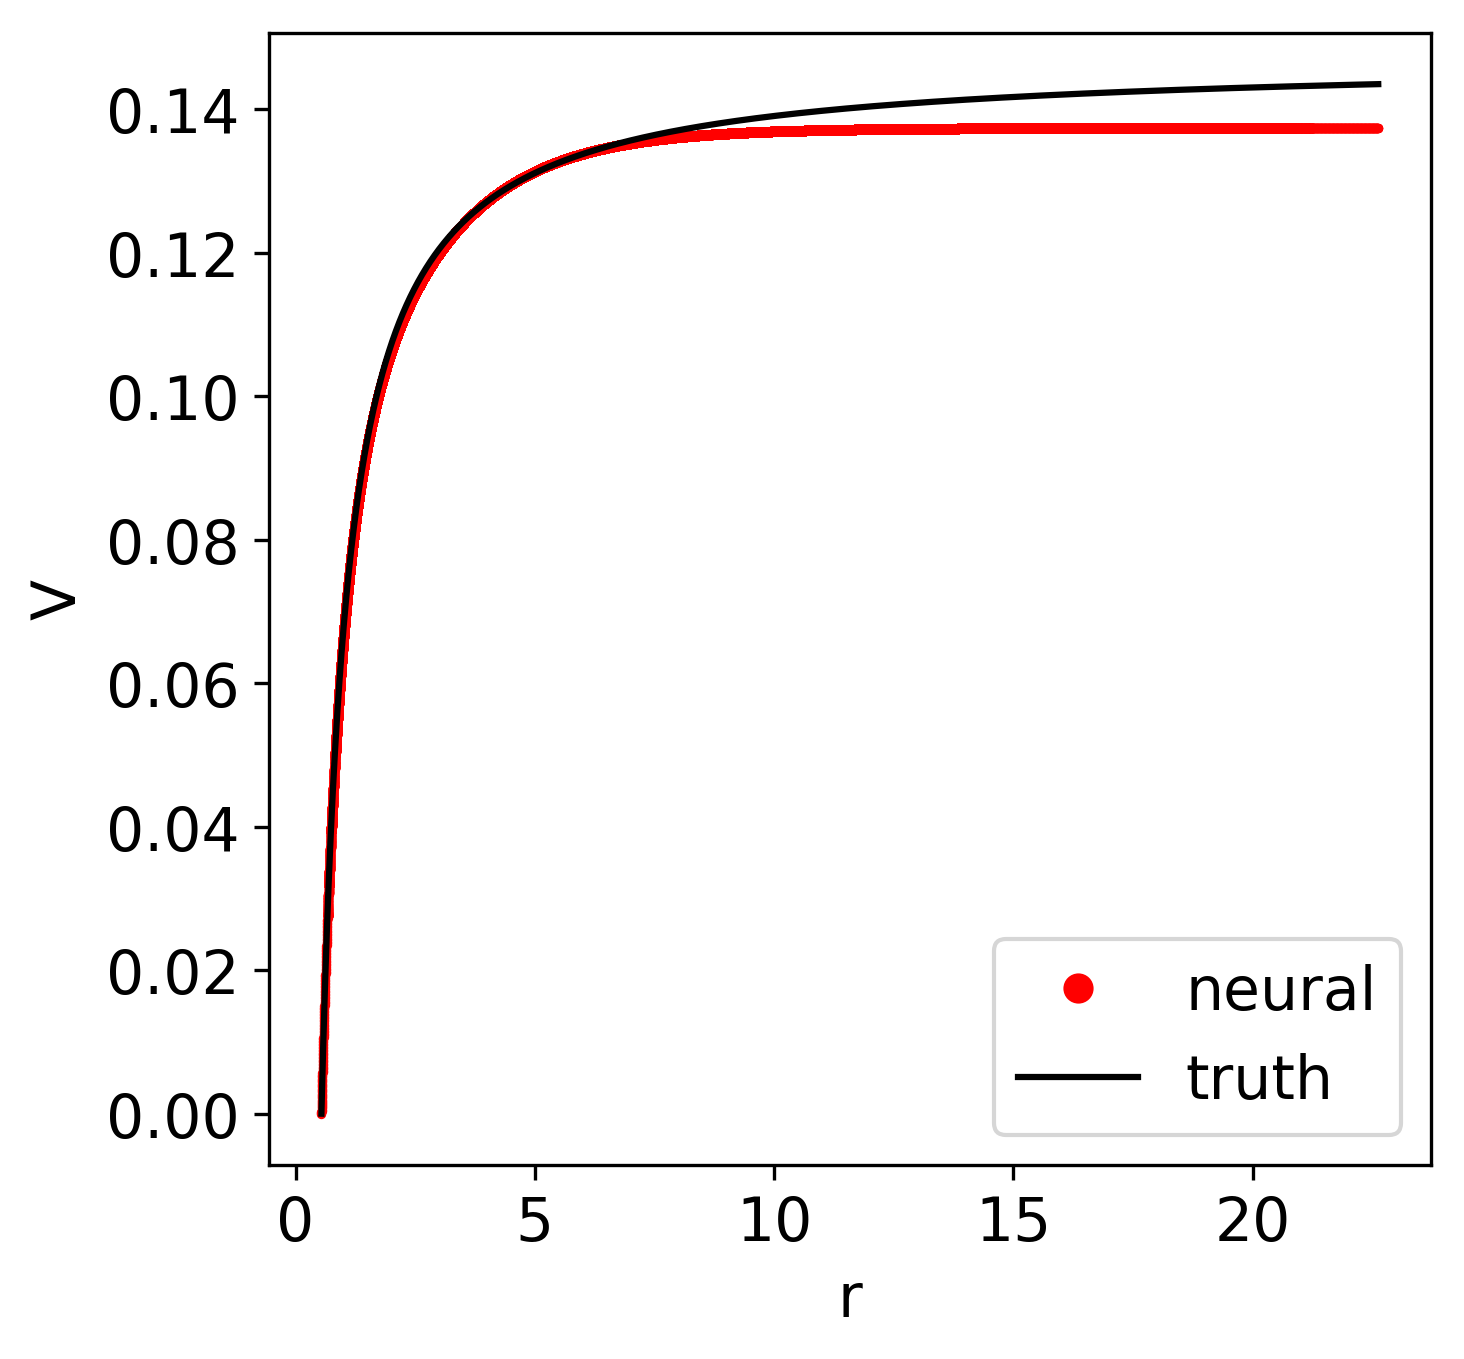

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5),dpi=300) 
rvals = np.linalg.norm(qdatpts[:,:3]-qdatpts[:,3:],axis=1)
plt.plot(rvals,Vplotpts - np.min(Vplotpts),'r.',ms=2.5, label='neural',rasterized=True)
rvals2 = np.sort(rvals)
plt.plot(rvals2, -1/(4*np.pi*rvals2) - np.min(-1/(4*np.pi*rvals2)),'k-',lw=1.5, label='truth')
plt.xlabel('r')
plt.ylabel('V')
# plt.plot(np.sort(qdatpts),0.5*np.sort(qdatpts)**2,'k-',lw=1.0)
plt.legend(markerscale=5)
plt.savefig('pot2train.pdf')
plt.show()

In [20]:
np.savetxt(fname='pot2Vtrain.csv', X=Vplotpts, delimiter=',')
np.savetxt(fname='pot2rtrain.csv', X=rvals, delimiter=',')
